# BERT -> Adversarial Membership Inference Attack

This notebook demonstrates a membership inference attack where we predict whether a data point was used to train a model (member) or not (non-member), using BERT embeddings and neural networks.

## Step 1: Install Required Libraries

In [ ]:
!pip install -U scikit-learn numpy matplotlib pandas tensorflow transformers torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 52.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 56.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 81.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 73.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.7/620.7 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 67.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 76.9 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: tensorboard
    Found existing installat

## Step 2: Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.utils import resample
from sklearn.metrics import roc_auc_score, roc_curve

import torch
from transformers import BertTokenizer, BertModel
import tensorflow as tf
from tensorflow.keras import layers, models


## Step 3: Load and Prepare Dataset

In [ ]:
# Update the path to your dataset
LABEL_COL = 'interview_round'
df = pd.read_csv('EduPilot_dataset.csv')
df = df.dropna(subset=[LABEL_COL])

# Encode labels
label_words = sorted(df[LABEL_COL].unique())
label_to_id = {w: i for i, w in enumerate(label_words)}
y = df[LABEL_COL].map(label_to_id).astype(int).values

# Combine text columns
text_cols = ['user_query', 'job_role', 'company', 'location', 'mock_question']
df['text'] = df[text_cols].fillna('').agg(' | '.join, axis=1)
texts = df['text'].tolist()

## Step 4: Encode Texts Using BERT

In [ ]:
# Load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')
bert_model.eval()  # disable training

# Function to get CLS embeddings for all texts
def get_bert_embeddings(texts, max_len=128):
    all_embeddings = []
    with torch.no_grad():
        for text in texts:
            inputs = tokenizer(text, return_tensors='pt', truncation=True, padding='max_length', max_length=max_len)
            outputs = bert_model(**inputs)
            cls_embedding = outputs.last_hidden_state[:,0,:].squeeze().numpy()  # CLS token embedding
            all_embeddings.append(cls_embedding)
    return np.array(all_embeddings)

# Generate BERT embeddings
X = get_bert_embeddings(texts)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

## Step 5: Split Data Into Train and Test

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.35, stratify=y, random_state=42
)
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

Train shape: (78, 768), Test shape: (42, 768)


## Step 6: Train Victim Model

In [ ]:
victim = MLPClassifier(hidden_layer_sizes=(128,), max_iter=300, random_state=123)
victim.fit(X_train, y_train)

# Function to calculate per-example loss
def per_example_loss(model, Xmat, y_true, eps=1e-12):
    proba = model.predict_proba(Xmat)
    rows = np.arange(Xmat.shape[0])
    p_true = np.clip(proba[rows, y_true], eps, 1.0-eps)
    return -np.log(p_true)

train_losses = per_example_loss(victim, X_train, y_train)
test_losses = per_example_loss(victim, X_test, y_test)
print(f"Victim train mean loss: {train_losses.mean():.4f}")
print(f"Victim test mean loss: {test_losses.mean():.4f}")


Victim train mean loss: 0.0022
Victim test mean loss: 0.0736


## Step 7: Train Shadow Models and Generate Attack Features

In [ ]:
K_SHADOWS = 10  # reduce for speed; can increase later
attack_X = []
attack_y = []

def entropy(proba):
    return -np.sum(proba * np.log(proba + 1e-12), axis=1)

for k in range(K_SHADOWS):
    idx = np.arange(X_train.shape[0])
    tr_idx = resample(idx, n_samples=int(0.6*len(idx)), replace=True, random_state=1000+k)
    te_idx = resample(idx, n_samples=int(0.4*len(idx)), replace=True, random_state=2000+k)

    Xs_tr, ys_tr = X_train[tr_idx], y_train[tr_idx]
    Xs_te, ys_te = X_train[te_idx], y_train[te_idx]

    sh = MLPClassifier(hidden_layer_sizes=(128,), max_iter=200, random_state=42+k)
    sh.fit(Xs_tr, ys_tr)

    # Member examples
    proba_tr = sh.predict_proba(Xs_tr)
    loss_tr = per_example_loss(sh, Xs_tr, ys_tr)
    ent_tr = entropy(proba_tr)
    for i in range(len(loss_tr)):
        attack_X.append(np.concatenate([proba_tr[i], [loss_tr[i], ent_tr[i]]]))
        attack_y.append(1)

    # Non-member examples
    proba_te = sh.predict_proba(Xs_te)
    loss_te = per_example_loss(sh, Xs_te, ys_te)
    ent_te = entropy(proba_te)
    for i in range(len(loss_te)):
        attack_X.append(np.concatenate([proba_te[i], [loss_te[i], ent_te[i]]]))
        attack_y.append(0)

attack_X = np.array(attack_X)
attack_y = np.array(attack_y)
print(f"Attack data shape: {attack_X.shape}")


Attack data shape: (770, 7)


## Step 8: Train Adversarial Attack Model

In [ ]:
attack_X_train, attack_X_val, attack_y_train, attack_y_val = train_test_split(
    attack_X, attack_y, test_size=0.2, stratify=attack_y, random_state=42
)

input_dim = attack_X.shape[1]
attack_model = models.Sequential([
    layers.Dense(64, activation='relu', input_shape=(input_dim,)),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])
attack_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = attack_model.fit(
    attack_X_train, attack_y_train,
    epochs=15, batch_size=64,
    validation_data=(attack_X_val, attack_y_val),
    verbose=1
)


Epoch 1/15


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.4268 - loss: 0.7064 - val_accuracy: 0.4740 - val_loss: 0.6894
Epoch 2/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5971 - loss: 0.6813 - val_accuracy: 0.6429 - val_loss: 0.6721
Epoch 3/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6511 - loss: 0.6661 - val_accuracy: 0.6364 - val_loss: 0.6601
Epoch 4/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6707 - loss: 0.6539 - val_accuracy: 0.6364 - val_loss: 0.6509
Epoch 5/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6605 - loss: 0.6468 - val_accuracy: 0.6364 - val_loss: 0.6435
Epoch 6/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6949 - loss: 0.6252 - val_accuracy: 0.6364 - val_loss: 0.6371
Epoch 7/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6595 - loss: 0.6317 - val_accuracy: 0.6429 - val_loss: 0.6321
Epoch 8/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6933 - loss: 0.6116 - val_accuracy: 0.6429 - val_loss: 0.

## Step 9: Evaluate Adversarial Attack

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Adversarial Attack ROC-AUC: 0.7518


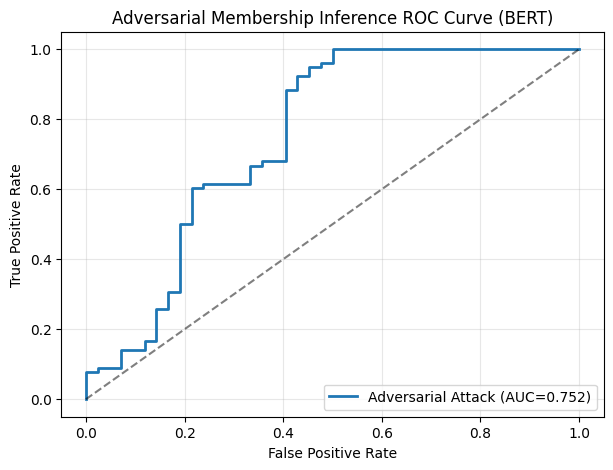

In [ ]:
victim_proba_train = victim.predict_proba(X_train)
victim_loss_train = per_example_loss(victim, X_train, y_train)
victim_ent_train = -np.sum(victim_proba_train * np.log(victim_proba_train + 1e-12), axis=1)

victim_proba_test = victim.predict_proba(X_test)
victim_loss_test = per_example_loss(victim, X_test, y_test)
victim_ent_test = -np.sum(victim_proba_test * np.log(victim_proba_test + 1e-12), axis=1)

victim_attack_X = np.concatenate([
    np.concatenate([victim_proba_train, victim_loss_train[:,None], victim_ent_train[:,None]], axis=1),
    np.concatenate([victim_proba_test, victim_loss_test[:,None], victim_ent_test[:,None]], axis=1)
], axis=0)
victim_attack_y = np.concatenate([np.ones_like(victim_loss_train), np.zeros_like(victim_loss_test)])

attack_pred = attack_model.predict(victim_attack_X).flatten()
auc = roc_auc_score(victim_attack_y, attack_pred)
fpr, tpr, _ = roc_curve(victim_attack_y, attack_pred)

print(f"Adversarial Attack ROC-AUC: {auc:.4f}")
plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, label=f'Adversarial Attack (AUC={auc:.3f})', lw=2)
plt.plot([0,1],[0,1],'k--', alpha=0.5)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Adversarial Membership Inference ROC Curve (BERT)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()
